In [21]:
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
import cv2

REPO_DIR = Path(".").resolve().parents[0]
# print(REPO_DIR)
sys.path.append(REPO_DIR.as_posix())

from limap_extension.optical_flow import motion_segmentation, Args, OpticalFlow
from limap_extension.img_cloud_transforms import reproject_img, uvz_ned_to_xyz_cam, xyz_cam_to_uvz_ned, index_img_with_uv_coords, get_uv_coords, imgs_to_clouds_np
from limap_extension.transforms_spatial import get_transform_matrix_from_pose_array
from limap_extension.bounding_box import BoundingBox

# from limap_extension.visualization.rerun.figure_factory import FigureFactory

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
# TRIAL_DIR = REPO_DIR / "datasets" / "ocean" / "Hard" / "P006"
TRIAL_DIR = REPO_DIR / "datasets" / "carwelding" / "easy" / "P007"
FRAME_1 = 150
FRAME_2 = 151
RAFT_PATH = REPO_DIR / "raft-sintel.pth"


In [78]:
# Load in the data.
frame_str = f"{FRAME_1:06d}"
rgb_1 = np.array(Image.open(TRIAL_DIR / "image_left" / f"{frame_str}_left.png"))
depth_1 = np.load(TRIAL_DIR / "depth_left" / f"{frame_str}_left_depth.npy")

frame_str = f"{FRAME_2:06d}"
rgb_2 = np.array(Image.open(TRIAL_DIR / "image_left" / f"{frame_str}_left.png"))
depth_2 = np.load(TRIAL_DIR / "depth_left" / f"{frame_str}_left_depth.npy")

cam_poses = np.loadtxt(TRIAL_DIR / "pose_left.txt")

In [79]:
# Opting to crop the depth images before input to reprojection
depth_max = 50
depth_1 = np.clip(depth_1, None, depth_max)
depth_2 = np.clip(depth_2, None, depth_max)

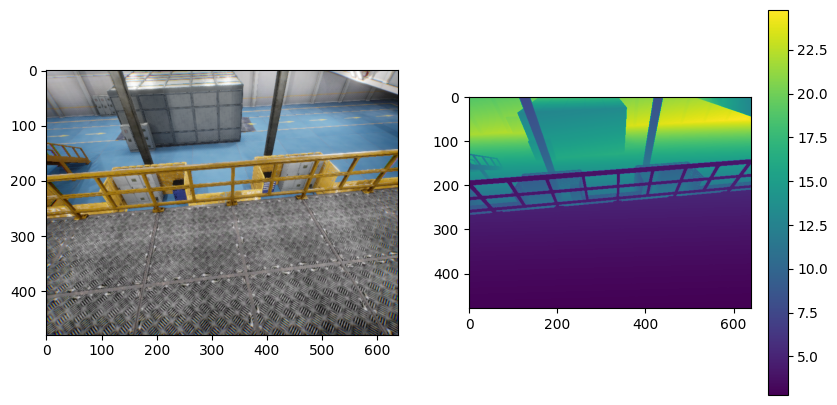

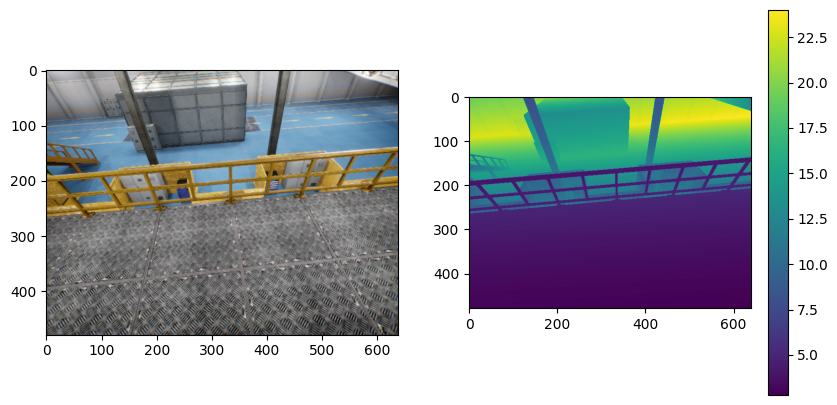

In [80]:
def display_img_pair(rgb, depth, img_slice: BoundingBox = None):
    if img_slice is not None:
        rgb = img_slice.crop_img(rgb)
        depth = img_slice.crop_img(depth)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(rgb)

    # depth = np.clip(depth, 0, 10)
    im1 = ax[1].imshow(depth)
    fig.colorbar(im1, ax=ax[1])


# crop_box = BoundingBox(200, 350, 125, 275)
# crop_box = BoundingBox(0, 100, 350, -1)
# crop_box = BoundingBox(325, 450, 180, 220)
crop_box = BoundingBox(0, -1, 0, -1)
display_img_pair(rgb_1, depth_1, crop_box)
display_img_pair(rgb_2, depth_2, crop_box)

In [81]:
flow = OpticalFlow(None)
flow.load_model(RAFT_PATH, Args())

In [82]:
cp1 = cam_poses[FRAME_1, :]
cp2 = cam_poses[FRAME_2, :]

In [83]:
pose_1 = get_transform_matrix_from_pose_array(cp1)
pose_2 = get_transform_matrix_from_pose_array(cp2)

In [84]:
# cloud_1, _ = imgs_to_clouds_np(rgb_1, depth_1, CAM_INTRINSIC)

U shape before flatten: (640, 480)
U max: 639 V max: 479
U[:10]: [0 1 2 3 4 5 6 7 8 9]
V[:10]: [0 0 0 0 0 0 0 0 0 0]
U[corner_idxs.upper_left] 0
V[corner_idxs.upper_left] 0
U[corner_idxs.upper_right] 639
V[corner_idxs.upper_right] 0
U[corner_idxs.lower_left] 0
V[corner_idxs.lower_left] 479
U[corner_idxs.lower_right] 639
V[corner_idxs.lower_right] 479
xyzs_img shape: (307200, 3)
xyz_cam mins: [  2.7890625  -21.875      -16.12783203]
xyz_cam maxes: [24.78125    24.04960938  2.14580688]
Number of invalid depths: 0
Corner indexes: [   0  639 -640   -1]
Cloud frame 1 maxes: [24.78125    24.04960938  2.14580688]
Cloud frame 1 mins: [  2.7890625  -21.875      -16.12783203]
Transformed Cloud maxes: [24.00849651 24.73784774  2.10051445]
Transformed Cloud mins: [  2.83672286 -21.23856867 -16.20647929]
us max: 659.4197006095155
vs max: 469.8408140320363
zs max: 24.00849651236815
us min: 16.921550401219918
vs min: -8.573631016594845
zs min: 2.836722864454171
BBox: u_min=22, u_max=622, v_min=9, v_m

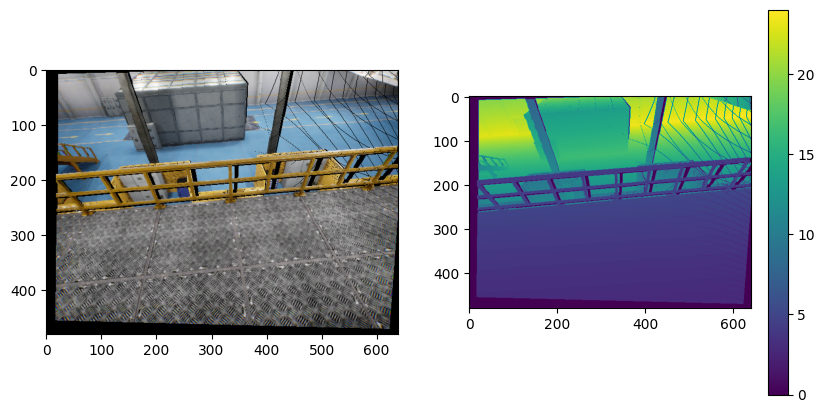

In [110]:
# Reproject the image at time t to the image frame at time t+1
img_1_in_frame_2, depth_1_in_frame_2, mask_valid_projection, valid_bbox = reproject_img(
    rgb_1, depth_1, pose_1, pose_2)

display_img_pair(img_1_in_frame_2, depth_1_in_frame_2)

# valid_bbox = BoundingBox(0, -1, 0, -1)

print(valid_bbox)

rgb_1_cropped = valid_bbox.crop_img(img_1_in_frame_2)
depth_1_cropped = valid_bbox.crop_img(depth_1_in_frame_2)
rgb_2_cropped = valid_bbox.crop_img(rgb_2)
depth_2_cropped = valid_bbox.crop_img(depth_2)
mask_valid_projection_cropped = valid_bbox.crop_img(mask_valid_projection)

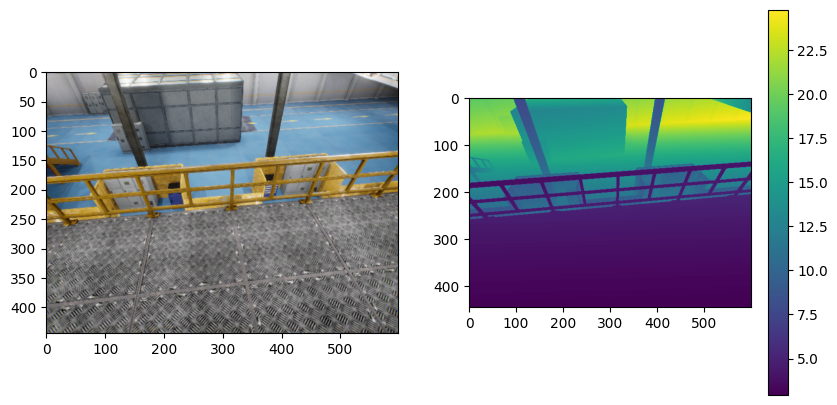

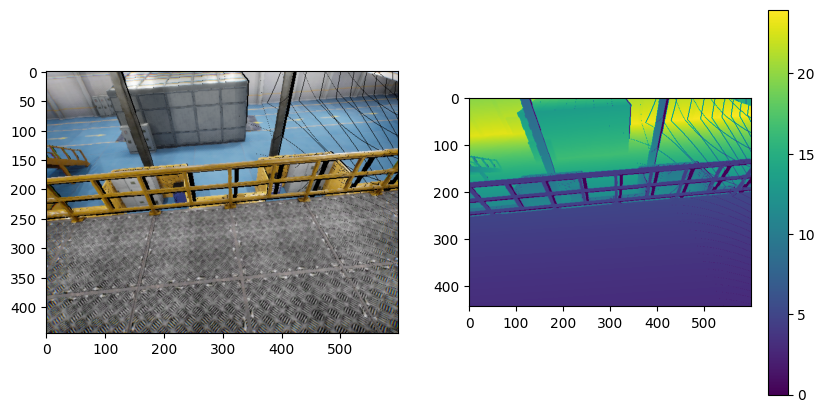

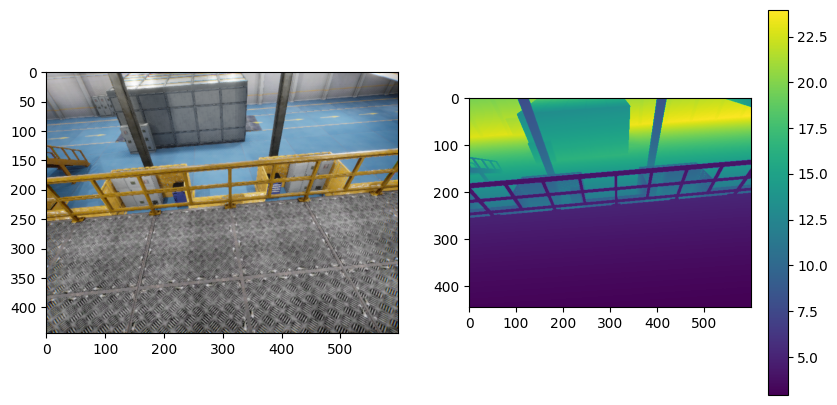

In [111]:
display_img_pair(valid_bbox.crop_img(rgb_1), valid_bbox.crop_img(depth_1), crop_box)
display_img_pair(rgb_1_cropped, depth_1_cropped, crop_box)

# fig, ax = plt.subplots(1, 2)
# ax[0].imshow(rgb_2_cropped)
# ax[1].imshow(depth_2_cropped)
display_img_pair(rgb_2_cropped, depth_2_cropped, crop_box)

Min depth disparity: 0.0


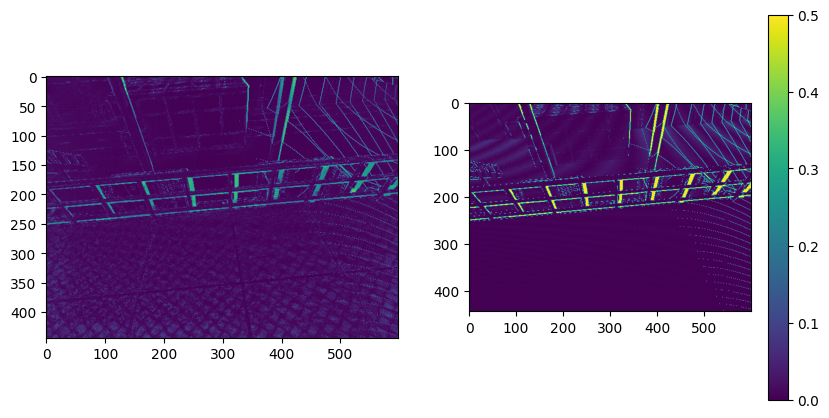

In [112]:
rgb_disparity = np.linalg.norm(rgb_1_cropped.astype(float) - rgb_2_cropped.astype(float), axis=-1)

# mean_disparity = np.mean(rgb_disparity)
# thresh_min = mean_disparity + np.std(rgb_disparity)
thresh_min = 0
rgb_disparity = np.clip(rgb_disparity, thresh_min, None)

# plt.figure()
# plt.imshow(rgb_disparity)
# plt.title("RGB Disparity")

depth_disparity = np.abs(depth_1_cropped - depth_2_cropped)
print("Min depth disparity:", np.min(depth_disparity))
# mean_disparity = np.mean(depth_disparity)
# thresh_min = mean_disparity + np.std(depth_disparity)
# depth_disparity = np.clip(depth_disparity, thresh_min, None)
# depth_disparity = np.clip(depth_disparity, 0, 0.2)
# plt.figure()
# plt.imshow(depth_disparity)
# plt.title("Depth Disparity")
# plt.colorbar()

depth_disparity = np.clip(depth_disparity, 0, 0.5)
display_img_pair(rgb_disparity, depth_disparity, crop_box)

In [113]:
crop_box.crop_img(depth_disparity).min()

0.0

In [114]:
# test_1 = np.zeros((100, 100, 3), dtype=np.uint8)
# test_1[40:60, 40:60, :] = 255
# test_2 = np.zeros((100, 100, 3), dtype=np.uint8)
# test_2[40:60, 50:70, :] = 255
# _, flow_test = flow.infer_flow(test_1, test_2)
# flow_test = flow_up = flow_test[0].permute(1, 2, 0).cpu().numpy()

# plt.figure()
# plt.imshow(test_1)

# plt.figure()
# plt.imshow(test_2)

# plt.figure()
# plt.imshow(flow_test[..., 0])

# plt.figure()
# plt.imshow(flow_test[..., 1])

In [115]:
flow_low, flow_up = flow.infer_flow(rgb_1_cropped, rgb_2_cropped)
# flow_low, flow_up = flow.infer_flow(rgb_2_cropped, rgb_1_cropped)
# flow_low, flow_up = flow.infer_flow(rgb_1, rgb_2)


In [116]:
print("Cropped shape:", rgb_1_cropped.shape)
print("Flow up shape:", flow_up.shape)

Cropped shape: (445, 600, 3)
Flow up shape: torch.Size([1, 2, 445, 600])


In [117]:
# print(flow_up, flow_low)
flow_up = flow_up[0].permute(1, 2, 0).cpu().numpy()


Text(0.5, 1.0, 'Flow Magnitude')

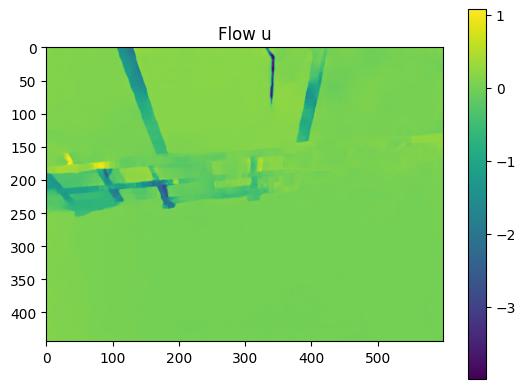

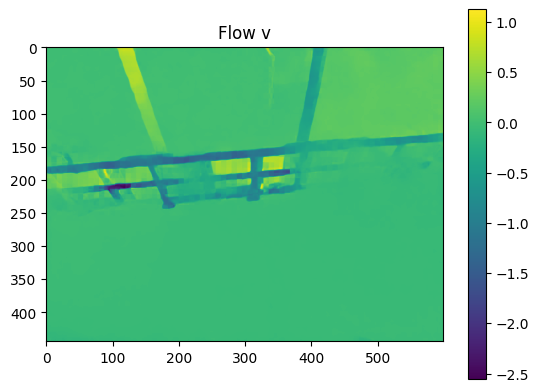

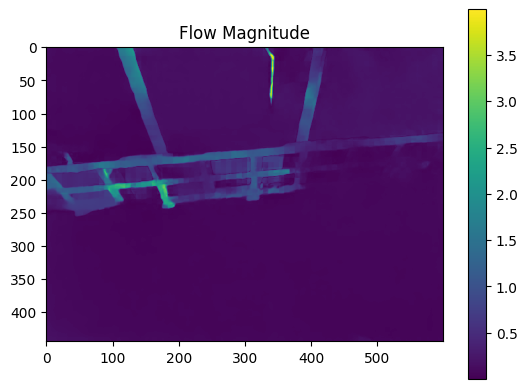

In [118]:
flow_up.shape

plt.figure()
plt.imshow(crop_box.crop_img(flow_up[..., 0]))
plt.colorbar()
plt.title("Flow u")

plt.figure()
plt.imshow(crop_box.crop_img(flow_up[..., 1]))
plt.colorbar()
plt.title("Flow v")

plt.figure()
plt.imshow(np.linalg.norm(flow_up, axis=-1))
plt.colorbar()
plt.title("Flow Magnitude")

In [119]:
# print("mag shape:", mag.shape)
print("rgb 1 cropped shape:", rgb_1_cropped.shape)

# 4. Use the flow to, for each pixel, compute the index at time t + 1 from time t (just each pixel's
#    image space coordinate in image 1's transformed frame)
#     1. This would entail computing the dx, dy image space coordinate change from the flow's
#        magnitude and angle channels (output), then adding that to the meshgrid coordinates (the
#        coordinates at time t)
img_width = rgb_1_cropped.shape[1]
img_height = rgb_1_cropped.shape[0]
# v_coords_1, u_coords_1 = np.meshgrid(np.arange(img_width), np.arange(img_height))
u_coords_1, v_coords_1 = get_uv_coords(img_height, img_width)
u_coords_1 = u_coords_1.flatten()
v_coords_1 = v_coords_1.flatten()
z_vals_1 = depth_1_cropped.flatten()

# mag_flat = mag.flatten()

# TODO: Is this angle in the same coordinate frame as the image?
# e.g. might have to flip the angle, rotate by 90 degrees, etc.
# angle_flat = angle.flatten() / 180 * np.pi

# du = np.round(mag_flat * np.cos(angle_flat)).astype(int)
# dv = np.round(mag_flat * np.sin(angle_flat)).astype(int)
dv = np.round(flow_up[..., 0].flatten()).astype(int)
du = np.round(flow_up[..., 1].flatten()).astype(int)

# Subtracting coordinates since coordinate frames for flow and images are different
u_coords_2 = u_coords_1 + du
v_coords_2 = v_coords_1 + dv


rgb 1 cropped shape: (445, 600, 3)
U shape before flatten: (600, 445)
U max: 599 V max: 444


In [120]:
# u_coords_1.max()
print(rgb_1_cropped[v_coords_1, u_coords_1, 0].shape)
print(img_height * img_width)

(267000,)
267000


In [121]:
# TODO: Cut out all coordinates that are out of bounds
# mask_valid_points = np.ones((img_height, img_width), dtype=bool)
coords_valid = np.ones_like(u_coords_2, dtype=bool)
# us_invalid = (u_coords_2 < 0) & (u_coords_2 >= img_width)
# vs_invalid = (v_coords_2 < 0) & (v_coords_2 >= img_height)
coords_valid[u_coords_2 < 0] = False
coords_valid[u_coords_2 >= img_width] = False
coords_valid[v_coords_2 < 0] = False
coords_valid[v_coords_2 >= img_height] = False
# coords_invalid = us_invalid | vs_invalid
# mask_valid_points[coords_invalid] = False
proj_valid = mask_valid_projection_cropped.flatten()
coords_valid = coords_valid & proj_valid

u_coords_2_valid = u_coords_2[coords_valid]
v_coords_2_valid = v_coords_2[coords_valid]

z_vals_2 = depth_2_cropped[v_coords_2_valid, u_coords_2_valid]
# z_vals_2 = depth_2_cropped[v_coords_2_valid, u_coords_2_valid]
# z_coords_2 = depth_2_cropped.flatten()

In [122]:
crop_shape = rgb_1_cropped.shape

print(crop_shape)

print("Image 1 shape:", rgb_1.shape)
print("u min crop:", valid_bbox.u_min)
print("u max crop:", valid_bbox.u_max)
print("v min crop:", valid_bbox.v_min)
print("v max crop:", valid_bbox.v_max)

(445, 600, 3)
Image 1 shape: (480, 640, 3)
u min crop: 22
u max crop: 622
v min crop: 9
v max crop: 454


In [123]:
u_coords_1_valid = u_coords_1[coords_valid]
v_coords_1_valid = v_coords_1[coords_valid]
z_vals_1_valid = z_vals_1[coords_valid]

# TODO: The intrinsic expects the UV coordinates to be generated based on images that are (480, 640)
# but due to how we're cropping things, the UV coordinates are generated based on the cropped images
# that could be quite different. We need to adjust the UV coordinates to be based on the original
# image size.
us_fixed = u_coords_1_valid + valid_bbox.u_min
vs_fixed = v_coords_1_valid + valid_bbox.v_min

xyz_1 = uvz_ned_to_xyz_cam(u_coords_1_valid, v_coords_1_valid, z_vals_1_valid)
xyz_2 = uvz_ned_to_xyz_cam(u_coords_2_valid, v_coords_2_valid, z_vals_2)

xyzs_img shape: (258047, 3)
xyzs_img shape: (258047, 3)


Min disparity: -13.981827
Max disparity: 14.271334


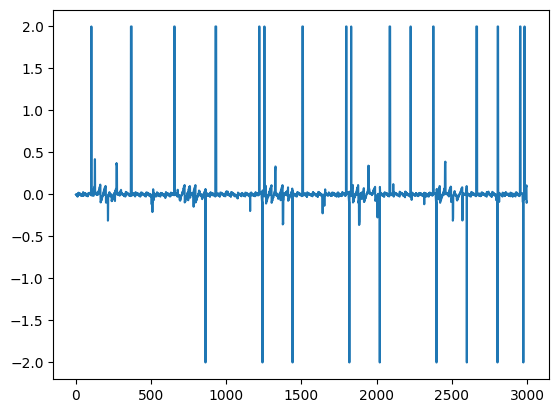

In [124]:
z_disparity = z_vals_1_valid - z_vals_2

print("Min disparity:", z_disparity.min())
print("Max disparity:", z_disparity.max())

z_disparity[z_disparity < -2] = -2
z_disparity[z_disparity > 2] = 2

plt.figure()
plt.plot(z_disparity[:3000])

In [125]:
xyz_2.shape

(258047, 3)

In [126]:
# 5. Project these two images into a point cloud
# convert the point cloud using grid coordinates and depths
# Just use intrinsic
# xyz_1 = np.random.rand(IMG_HEIGHT * IMG_WIDTH, 3)
# xyz_2 = np.random.rand(IMG_HEIGHT * IMG_WIDTH, 3)

# 6. Index point cloud 1 with coordinate at time t, point cloud 2 with coordinate at time t +1,
# 7. Compute Euclidean distance
flow_3d = np.linalg.norm(xyz_1 - xyz_2, axis=1)

In [127]:
print("Flow min:", flow_3d.min())
print("Flow max:", flow_3d.max())

Flow min: 0.0
Flow max: 17.409503476016166


In [128]:
points_dynamic_mask = flow_3d > 0.1  # meters
# coords_dynamic_1 = xyz_1[points_dynamic_mask, :]
coords_dynamic_2 = xyz_2[points_dynamic_mask, :]


In [129]:
# 8. reproject the points back into image space with the distance being the value at each pixel
mask = np.zeros((img_height, img_width), dtype=np.uint8)
# reproject to image coordinates using funciton and intrinsic
us, vs, zs = xyz_cam_to_uvz_ned(coords_dynamic_2, is_rounding_to_int=True)

from limap_extension.img_cloud_transforms import find_valid_uv_coords

where_valid = find_valid_uv_coords(us, vs, img_height, img_width)
us = us[where_valid]
vs = vs[where_valid]

mask[vs, us] = 1

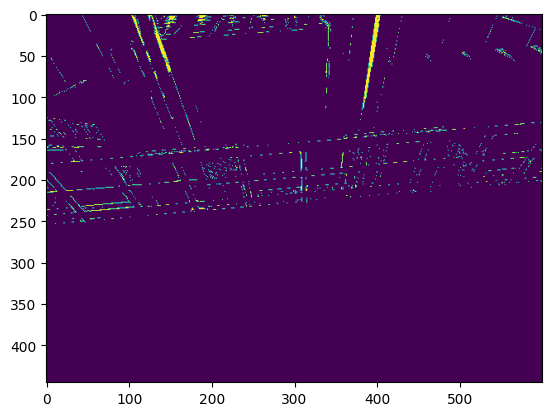

In [130]:
plt.figure()
plt.imshow(mask)

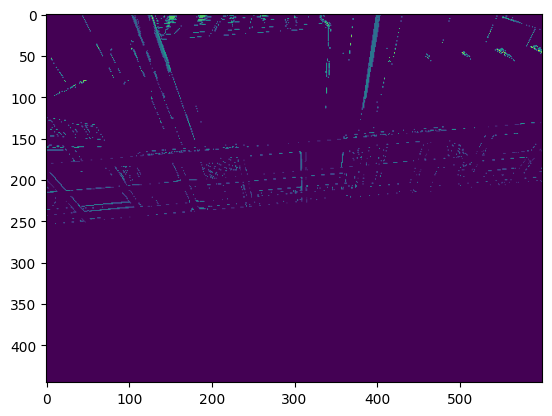

In [131]:
depth_reconstructed = np.zeros((img_height, img_width), dtype=np.float32)
depth_reconstructed[vs, us] = zs

threshold = 30
depth_reconstructed[depth_reconstructed > threshold] = threshold
plt.figure()
plt.imshow(depth_reconstructed)